In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Flatten,Dense,UpSampling2D,MaxPool2D,Input
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.preprocessing.image import img_to_array

# dataset's load_dataset
from datasets import load_dataset
# Tensorflow's model visualization
from tensorflow.keras.utils import plot_model

import random

In [2]:
dataset = load_dataset("valhalla/emoji-dataset")

### Explore the dataset

In [3]:
dataset['train']

Dataset({
    features: ['image', 'text'],
    num_rows: 2749
})

In [4]:
dataset['train'].features

{'image': Image(decode=True, id=None), 'text': Value(dtype='string', id=None)}

In [5]:
### No of images
dataset['train'].num_rows

2749

In [6]:
dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x16CD66F7A00>,
 'text': 'grinning face'}

grinning face


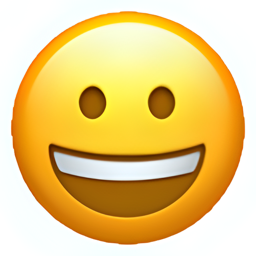

In [7]:
print(dataset['train'][0]['text'])
dataset['train'][0]['image']

In [8]:
def display_image(data,labels,indexes):

    # plot first few images
    plt.figure(figsize=(14,12))
    
    for i in range(len(indexes)):

        # Get image data
        img = data[indexes[i]]
        
        # Get text label
        text = labels[indexes[i]]
        
        
        # define subplot
        plt.subplot(330 + 1 + i)
        plt.title(text,fontsize=10)
        # plot raw pixel data
        plt.imshow(img)

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    
    # show the figure
    plt.show()
    

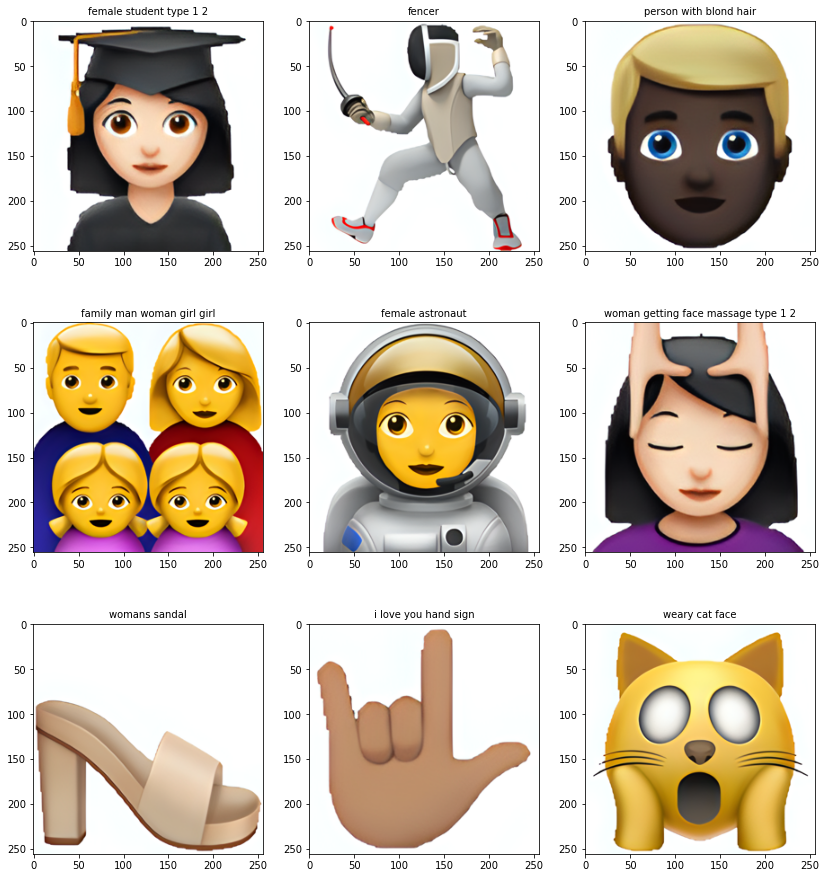

In [9]:
# plotting random images and their labels
no_of_images = 9 
indexes = [random.randint(0,dataset['train'].num_rows) for i in range(no_of_images)]
display_image(dataset['train']['image'],dataset['train']['text'],indexes)

### SPlit the images in train and test

In [10]:
def split_list_of_images(num_images,ratio):
    
    split_index = num_images*ratio
    
    split_index = int(np.round(split_index))
    
    x_train, x_test = dataset['train'][0:split_index]['image'], dataset['train'][split_index:]['image']
    y_train, y_test = dataset['train'][0:split_index]['text'], dataset['train'][split_index:]['text']
    
    return (x_train,y_train,x_test,y_test)

In [11]:
num_images = dataset['train'].num_rows

In [12]:
(x_train,y_train,x_test,y_test) = split_list_of_images(num_images,0.7)

### Image to array

In [13]:
x_train_lis =  [img_to_array(img) for img in x_train]
x_test_lis  =  [img_to_array(img) for img in x_test]

In [14]:
# converting list to array
x_train_arr = np.array(x_train_lis)
x_test_arr = np.array(x_test_lis)

## Normalise the Image

In [15]:
x_train_arr = x_train_arr/255.0
x_test_arr = x_test_arr/255.0

In [16]:
print("X_train shape",x_train_arr.shape)
print("X_test shape",x_test_arr.shape)

X_train shape (1924, 256, 256, 3)
X_test shape (825, 256, 256, 3)


## Encoder

In [17]:
input_shape = (256,256,3)

#input layer
encoder_input = Input(shape=input_shape,name='Input_Layer')

#1st hidden layer
encoder_hidden = Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',name='conv2d_1')(encoder_input)


#2nd hidden layer
encoder_hidden = MaxPool2D(pool_size=(2, 2),strides=(2,2),padding='same',name='Maxpool2D_1')(encoder_hidden)

#3rd hidden layer
encoder_hidden = Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',name='conv2d_2')(encoder_hidden)


#4th hidden layer
encoder_hidden = MaxPool2D(pool_size=(2, 2),strides=(2,2),padding='same',name='Maxpool2D_2')(encoder_hidden)

#5th hidden layer
encoder_hidden = Conv2D(filters=8,kernel_size=(3,3),padding='same',activation='relu',name='conv2d_3')(encoder_hidden)


#enocder output
encoder_output = MaxPool2D(pool_size=(2, 2),strides=(2,2),padding='same',name='Maxpool2D_3')(encoder_hidden)


## Decoder

In [18]:

#1st hidden layer
decoder_hidden = Conv2D(filters=8,kernel_size=(3,3),padding='same',activation='relu',name='conv2d_4')(encoder_output)

#2nd hidden layer
decoder_hidden = UpSampling2D(size=(2, 2),name='Upsampling_2D_1')(decoder_hidden)

#3rd hidden layer
decoder_hidden = Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',name='conv2d_5')(decoder_hidden)

#4th hidden layer
decoder_hidden = UpSampling2D(size=(2, 2),name='Upsampling_2D_2')(decoder_hidden)

#5th hidden layer
decoder_hidden = Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',name='conv2d_6')(decoder_hidden)

#6th hidden layer
decoder_hidden = UpSampling2D(size=(2, 2),name='Upsampling_2D_3')(decoder_hidden)


#output
decoder_output = Conv2D(filters=3,kernel_size=(3,3),padding='same',activation='relu',name='conv2d_7')(decoder_hidden)

In [19]:
# Create the autoencoder model
autoencoder = Model(inputs=encoder_input, outputs=decoder_output)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 Maxpool2D_1 (MaxPooling2D)  (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      4624      
                                                                 
 Maxpool2D_2 (MaxPooling2D)  (None, 64, 64, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 Maxpool2D_3 (MaxPooling2D)  (None, 32, 32, 8)         0     

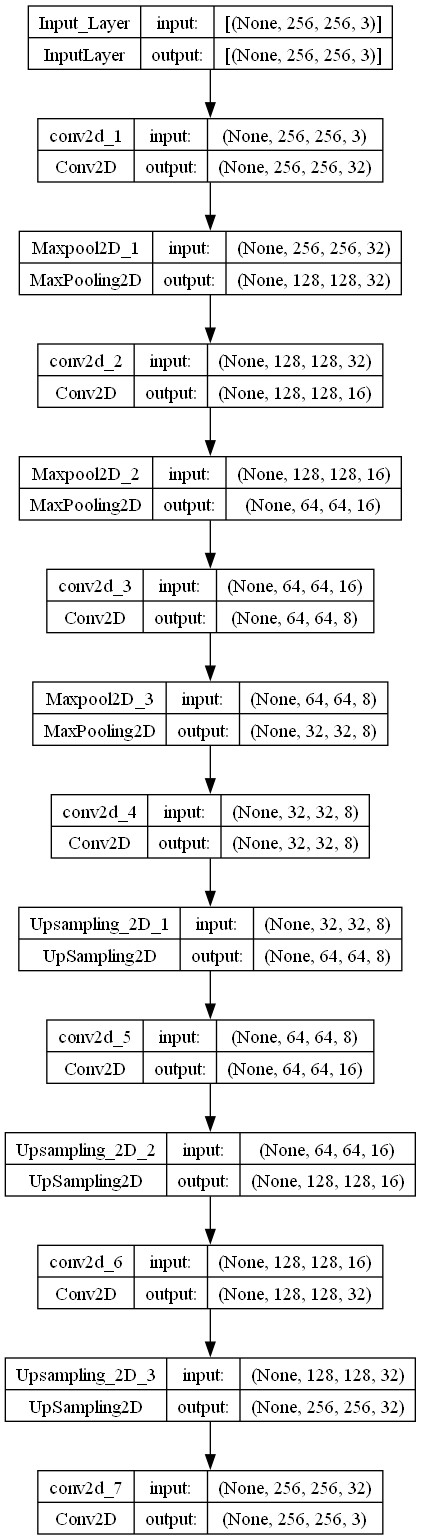

In [21]:
plot_model(autoencoder,  show_shapes=True)

## Denoising with Autoencoders

In [22]:
#add noise
noise_factor = 0.5
x_train_noisy = x_train_arr + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_arr.shape) 
x_test_noisy = x_test_arr + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_arr.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

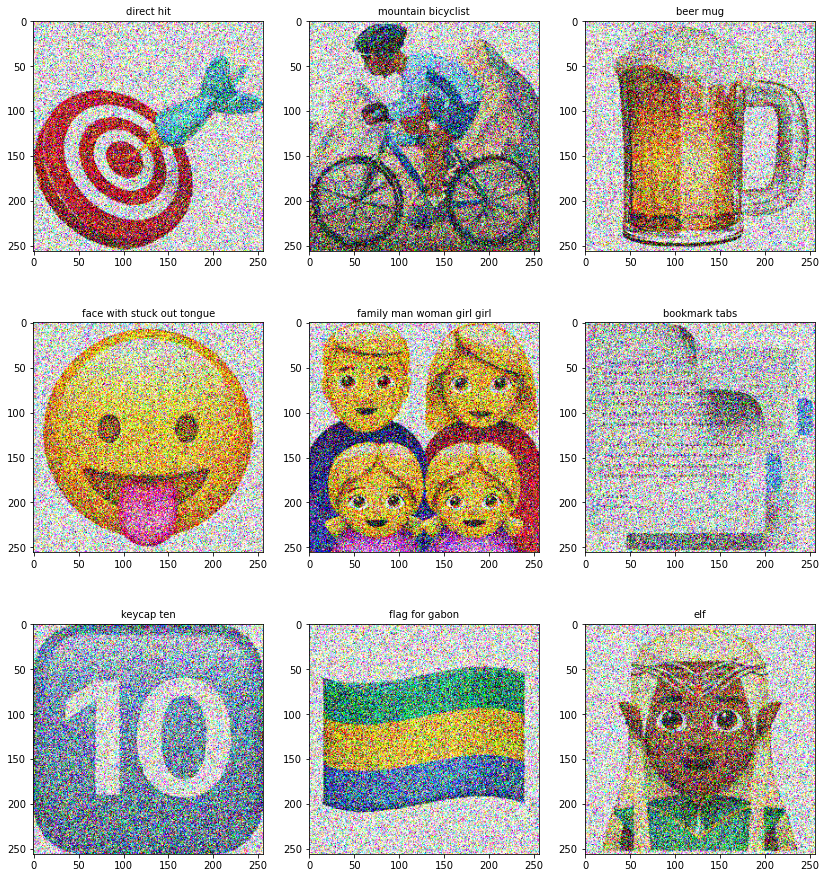

In [23]:
#plot noisy images
# plotting random images and their labels
no_of_images = 9 
indexes = [random.randint(0,len(x_train_noisy)) for i in range(no_of_images)]

display_image(x_train_noisy,y_train,indexes)

In [24]:
# Training
no_of_epochs = 15
history = autoencoder.fit(x_train_noisy, x_train_noisy, epochs=no_of_epochs, batch_size=128, validation_data=(x_test_noisy, x_test_noisy))

Epoch 1/15
16/16 [==============================] - 284s 15s/step - loss: 0.3648 - val_loss: 0.2737
Epoch 2/15
16/16 [==============================] - 226s 14s/step - loss: 0.2736 - val_loss: 0.2628
Epoch 3/15
16/16 [==============================] - 212s 13s/step - loss: 0.2641 - val_loss: 0.1936
Epoch 4/15
16/16 [==============================] - 211s 13s/step - loss: 0.1298 - val_loss: 0.1144
Epoch 5/15
16/16 [==============================] - 205s 13s/step - loss: 0.1094 - val_loss: 0.1102
Epoch 6/15
16/16 [==============================] - 207s 13s/step - loss: 0.1072 - val_loss: 0.1082
Epoch 7/15
16/16 [==============================] - 214s 13s/step - loss: 0.1061 - val_loss: 0.1078
Epoch 8/15
16/16 [==============================] - 223s 14s/step - loss: 0.1056 - val_loss: 0.1071
Epoch 9/15
16/16 [==============================] - 218s 14s/step - loss: 0.1051 - val_loss: 0.1066
Epoch 10/15
16/16 [==============================] - 236s 15s/step - loss: 0.1048 - val_loss: 0.1064

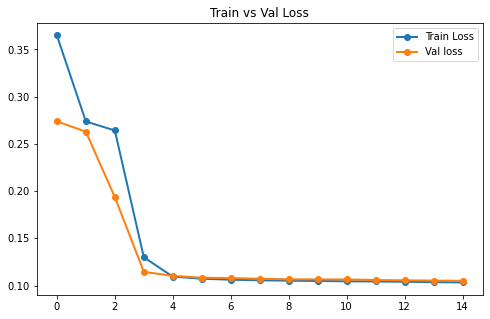

In [25]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig = plt.figure(figsize=(8,5))

plt.plot(list(range(no_of_epochs)),train_loss,marker='o',linewidth=2)
plt.plot(list(range(no_of_epochs)),val_loss,marker='o',linewidth=2)
plt.title("Train vs Val Loss")
plt.legend(["Train Loss", "Val loss"],loc = 'upper right')
plt.show()

In [26]:
autoencoder.save('autoencodermodel_noise.h5')

C:\Users\nswet\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
ae = load_model('autoencodermodel_noise.h5')

In [28]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 Maxpool2D_1 (MaxPooling2D)  (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      4624      
                                                                 
 Maxpool2D_2 (MaxPooling2D)  (None, 64, 64, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 Maxpool2D_3 (MaxPooling2D)  (None, 32, 32, 8)         0     

In [29]:
ae_predictions = ae.predict(x_test_noisy)

26/26 [==============================] - 13s 485ms/step


In [30]:
ae_predictions.shape

(825, 256, 256, 3)

In [31]:
ae_predictions[0].shape

(256, 256, 3)

## Compare the test and predictions

In [32]:
def display_predictions(x_test_noisy,predictions,y_test,indexes):

    # plot first few images
    plt.figure(figsize=(10,2))
    
    for i in range(len(indexes)):

        # Get true image data
        img1 = x_test_noisy[indexes[i]]
        
        # Get reconstructed image data
        img2 = predictions[indexes[i]]
        
        # Get text label
        text = y_test[indexes[i]]
            
        # define subplot
        plt.subplot(120 + 1 + i)
        plt.title(text,fontsize=10)
        # plot original img data
        plt.imshow(img1)

        plt.subplot(120 + 1 + i+1)
        plt.title(text,fontsize=10)
        # plot original img data
        plt.imshow(img2)

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    
    # show the figure
    plt.show()
    

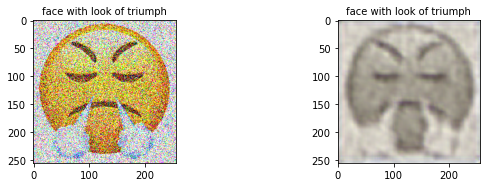

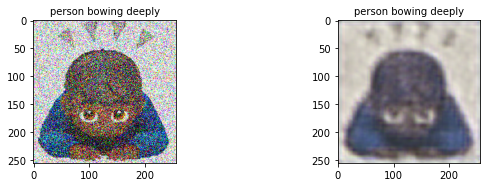

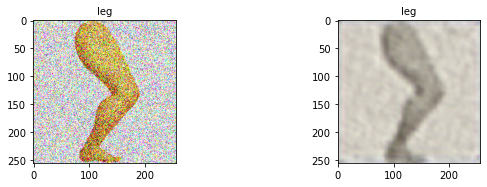

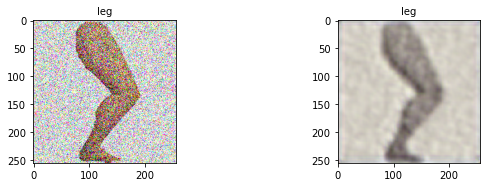

In [33]:
# plotting random images and their labels
no_of_images = 4 
indexes = [random.randint(0,len(x_test_noisy)) for i in range(no_of_images)]

for i in indexes:
    display_predictions(x_test_noisy,ae_predictions,y_test,[i])